
# Applications of DeepChem with Alphafold: Docking and protein-ligand interaction from protein sequence

Author: Sriphani Bellamkonda


In this tutorial we will explore a potential application where we combine the capabilities of Alphafold and DeepChem.

Alphafold2 has made immense strides in predicting protein structure folding with out the use of costly lab equipment and DeepChem has a number easy to use modules which can then be applied on protein structures.  

In the first part of our tutorial we will try to predict the protein structure given a protein sequence.

In the second part of out tutorial, we sample a few ligands from the protein-complex dataset(PDBbind) and perform programmatic docking to estimate binding affinities between our protein and a number of ligands.


This tutorial is meant to be run in google colab. You can follow the below link to open this notebook in colab.

<a target="_blank" href="https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/DeepChemXAlphafold.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Setup

We will first be installing deepchem as a runtime restart might be required.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install -c conda-forge openmm -y
!mkdir vina_test

!conda install -c conda-forge pdbfixer
!conda install -c conda-forge vina
!pip install deepchem



### **Restart may be prompted after installing  deepchem**

# Part 1: Predict Protein Structure in pdb format from a given input sequence

Note: The cells until part 2 of this tutorial are directly from the Colabfold's google colab implementation.

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.2-patch: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and read our manuscript.
Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)


In [1]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'test' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



jobname test_a5e17
sequence PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK
length 59


In [2]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("pip install --upgrade dm-haiku")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 195 ms, sys: 46.2 ms, total: 242 ms
Wall time: 1min 4s


In [3]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "auto" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use 20 recycles if `model_type=alphafold2_multimer_v3` (with tol=0.5), all else 3 recycles (with tol=0.0).
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

2023-09-20 04:19:41,310 Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-09-20 04:19:41,310 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-09-20 04:19:41,312 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2023-09-20 04:19:41,312 No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2023-09-20 04:19:41,312 WARNING: no GPU detected, will be using CPU
2023-09-20 04:19:43,380 Found 4 citations for tools or databases
2023-09-20 04:19:43,381 Query 1/1: test_a5e17 (length 59)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


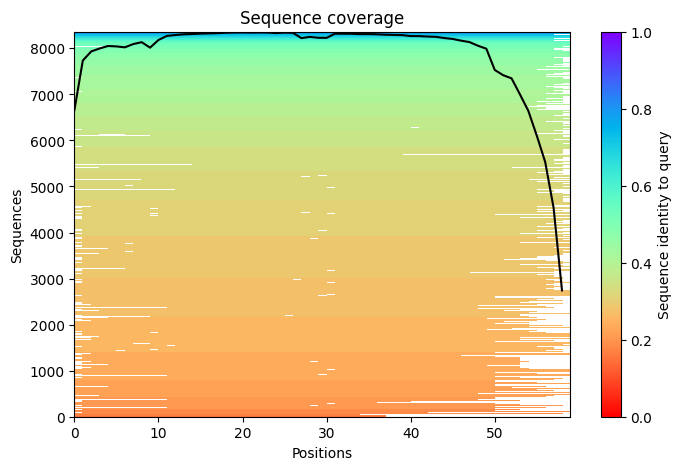

2023-09-20 04:19:44,833 Setting max_seq=512, max_extra_seq=5120
2023-09-20 04:22:20,068 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=96.6 pTM=0.755
2023-09-20 04:24:28,914 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=96.6 pTM=0.758 tol=0.295
2023-09-20 04:26:36,034 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=96.4 pTM=0.758 tol=0.0399
2023-09-20 04:28:43,284 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=96.2 pTM=0.757 tol=0.04
2023-09-20 04:28:43,285 alphafold2_ptm_model_1_seed_000 took 529.7s (3 recycles)


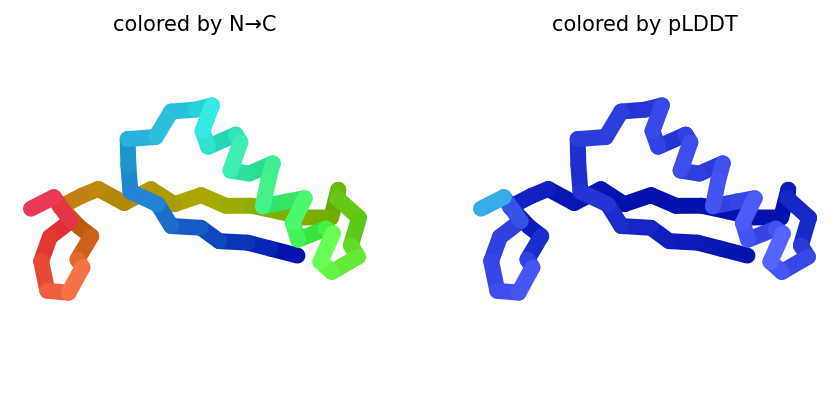

2023-09-20 04:30:51,877 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=96.9 pTM=0.76
2023-09-20 04:32:59,103 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=97 pTM=0.766 tol=0.364
2023-09-20 04:35:06,502 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=96.9 pTM=0.766 tol=0.123
2023-09-20 04:37:13,193 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=96.8 pTM=0.767 tol=0.0809
2023-09-20 04:37:13,195 alphafold2_ptm_model_2_seed_000 took 509.8s (3 recycles)


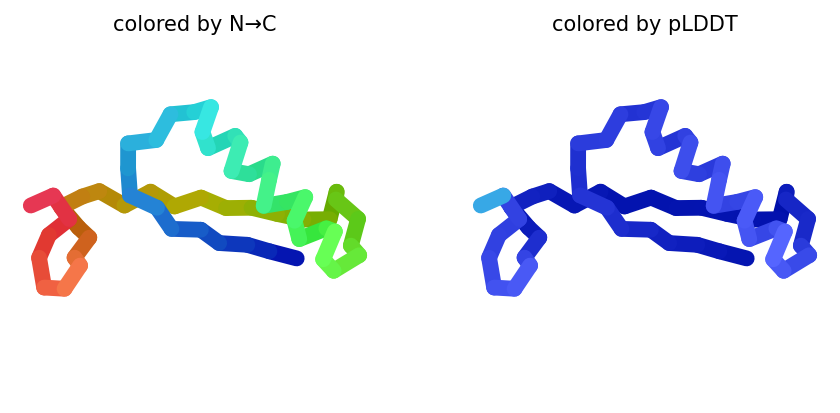

2023-09-20 04:39:21,188 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=97.2 pTM=0.775
2023-09-20 04:41:29,117 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=97.4 pTM=0.782 tol=0.289
2023-09-20 04:43:38,653 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=97.4 pTM=0.782 tol=0.117
2023-09-20 04:45:46,519 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=97.4 pTM=0.784 tol=0.0587
2023-09-20 04:45:46,520 alphafold2_ptm_model_3_seed_000 took 513.0s (3 recycles)


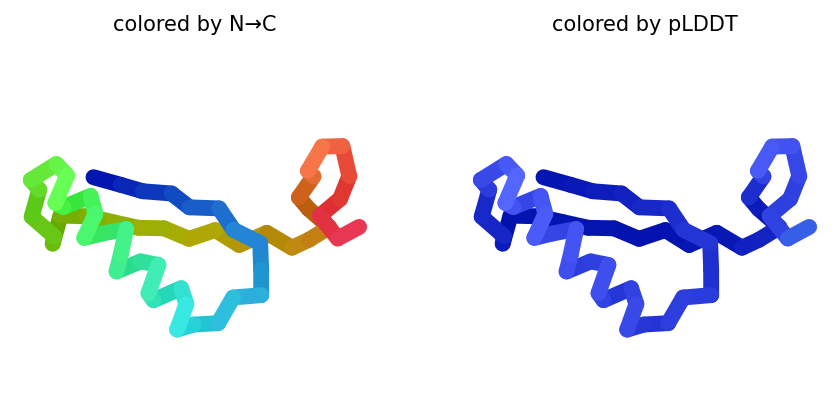

2023-09-20 04:47:52,903 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=97.4 pTM=0.775
2023-09-20 04:50:01,160 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=97.4 pTM=0.782 tol=0.29
2023-09-20 04:52:08,178 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=97.2 pTM=0.778 tol=0.0689
2023-09-20 04:54:18,538 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=97.1 pTM=0.778 tol=0.0392
2023-09-20 04:54:18,539 alphafold2_ptm_model_4_seed_000 took 511.9s (3 recycles)


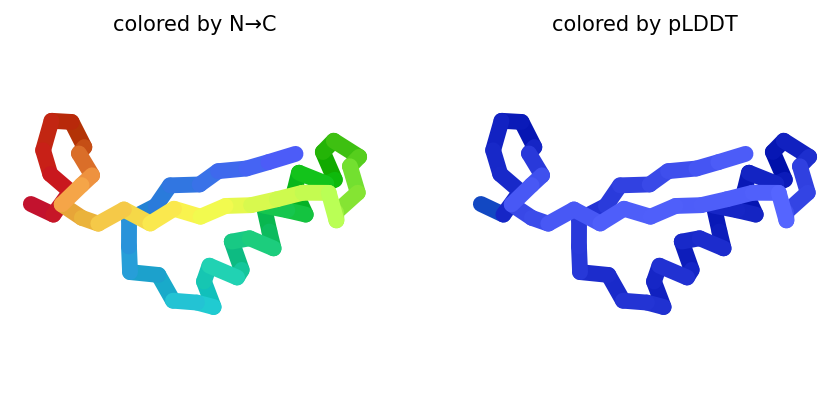

2023-09-20 04:56:28,180 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=97.4 pTM=0.784
2023-09-20 04:58:36,074 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=97.1 pTM=0.785 tol=0.229
2023-09-20 05:00:42,828 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=96.4 pTM=0.777 tol=0.166
2023-09-20 05:02:49,225 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=96.3 pTM=0.778 tol=0.132
2023-09-20 05:02:49,226 alphafold2_ptm_model_5_seed_000 took 510.6s (3 recycles)


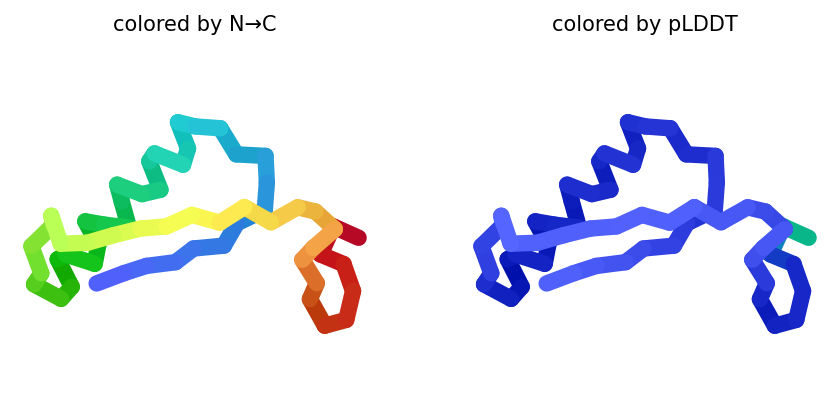

2023-09-20 05:02:49,346 reranking models by 'plddt' metric
2023-09-20 05:02:49,347 rank_001_alphafold2_ptm_model_3_seed_000 pLDDT=97.4 pTM=0.784
2023-09-20 05:02:49,348 rank_002_alphafold2_ptm_model_4_seed_000 pLDDT=97.1 pTM=0.778
2023-09-20 05:02:49,348 rank_003_alphafold2_ptm_model_2_seed_000 pLDDT=96.8 pTM=0.767
2023-09-20 05:02:49,349 rank_004_alphafold2_ptm_model_5_seed_000 pLDDT=96.3 pTM=0.778
2023-09-20 05:02:49,349 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=96.2 pTM=0.757
2023-09-20 05:02:51,109 Done


0

In [5]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
  setup_logging(Path(log_filename))
  logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

________ test_a5e17/test_a5e17_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb ['test_a5e17/test_a5e17_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb']


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

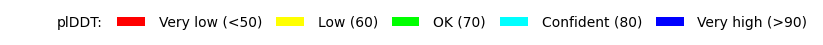

In [6]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

print("Files generated: ", pdb_filename, pdb_file)
pdb_filename_captured = pdb_filename

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


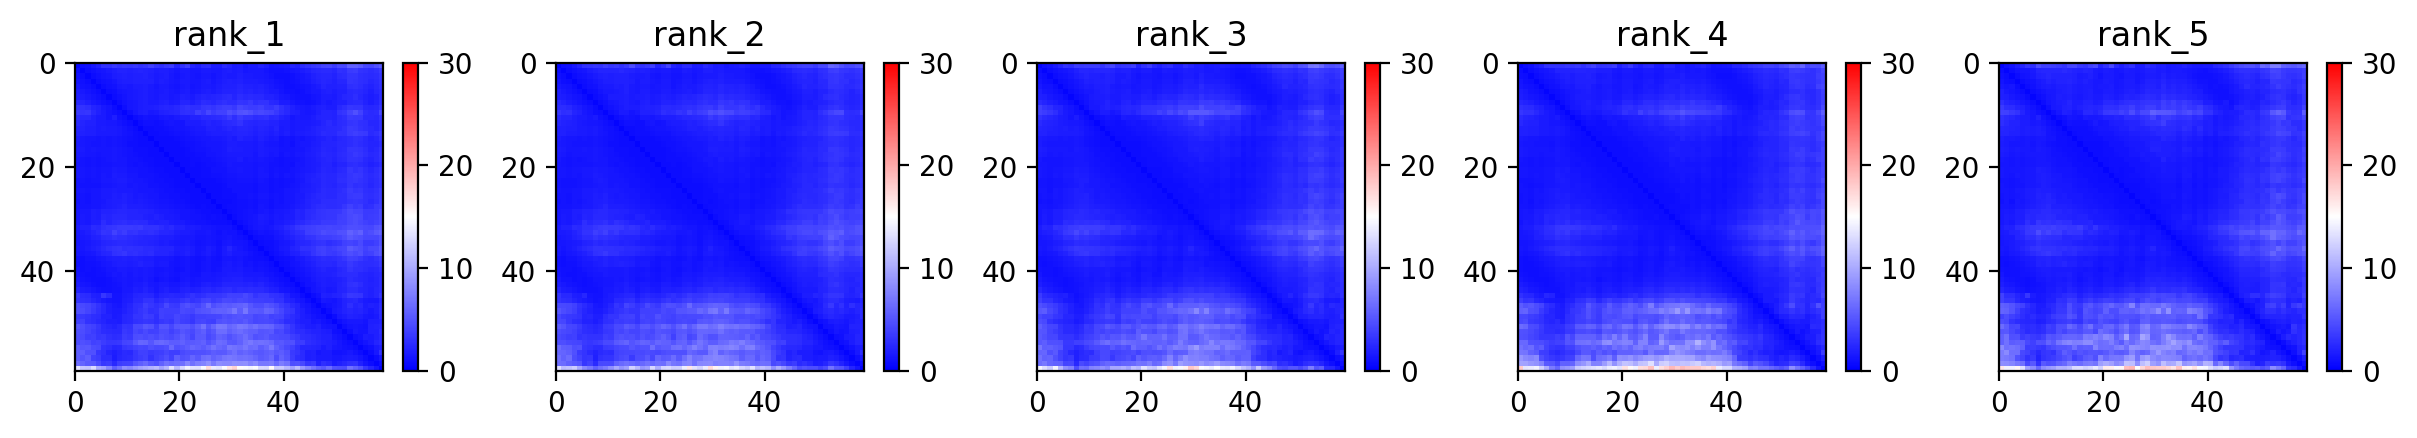
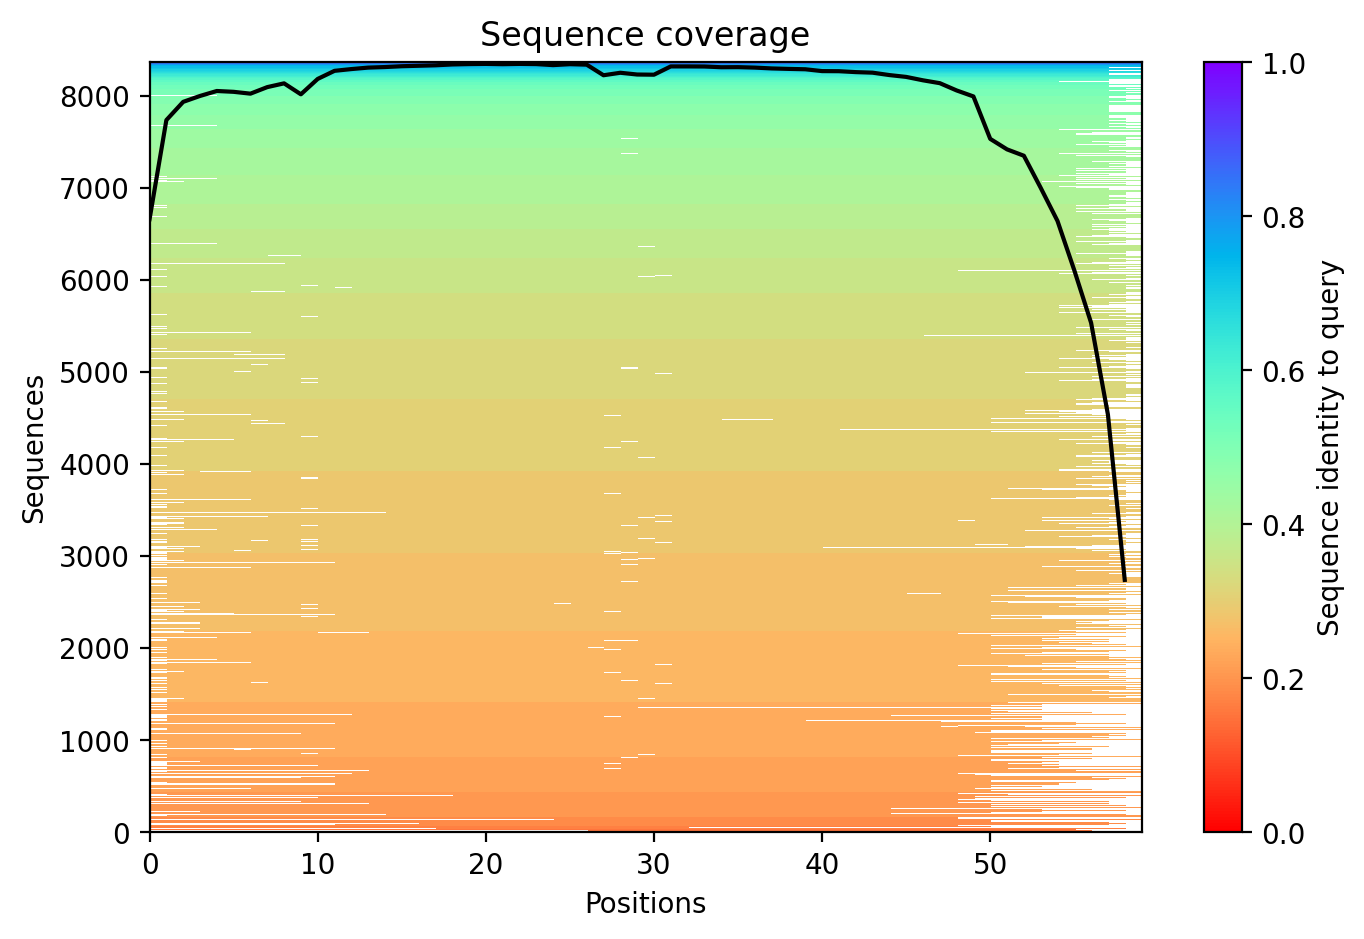
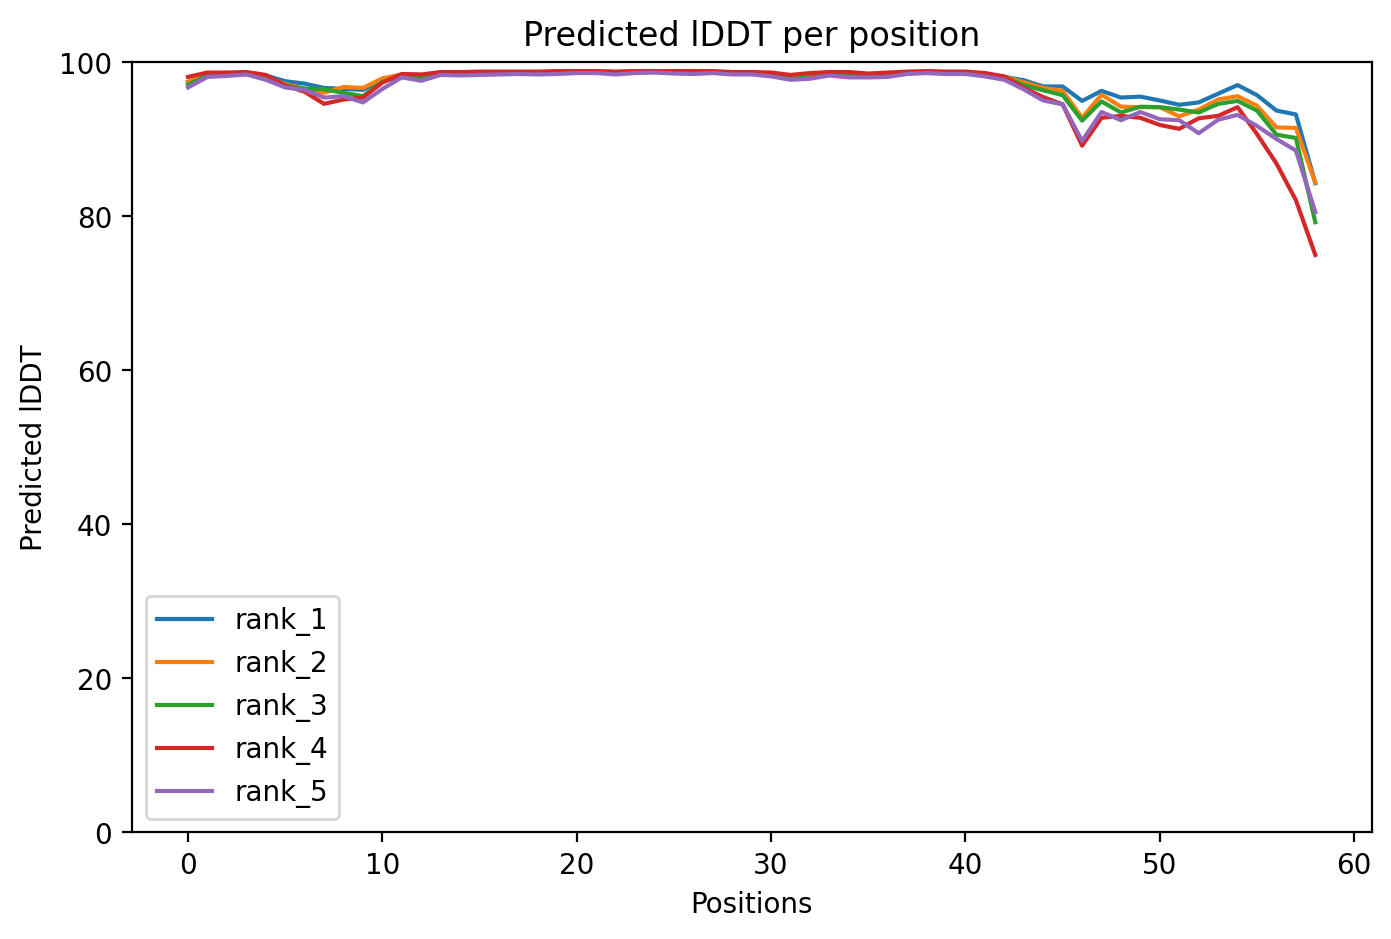

In [7]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


In [8]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Below we have captured the file path to the generated protein structure.

In [9]:
print(pdb_filename_captured)

test_a5e17/test_a5e17_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb


# Part 2: Estimate binding affinities between the predicted protein and a sample set of ligands


In [4]:
import os
import numpy as np
import pandas as pd

import tempfile

from rdkit import Chem
from rdkit.Chem import AllChem


import deepchem as dc

from deepchem.utils import download_url, load_from_disk

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/usr/local/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


To sample a set of ligands we will use [PDBind](http://www.pdbbind.org.cn/).

In [6]:
data_dir = dc.utils.get_data_dir()
dataset_file = os.path.join(data_dir, "pdbbind_core_df.csv.gz")

if not os.path.exists(dataset_file):
    print('File does not exist. Downloading file...')
    download_url("https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/pdbbind_core_df.csv.gz")
    print('File downloaded...')

raw_dataset = load_from_disk(dataset_file)
raw_dataset = raw_dataset[['pdb_id', 'smiles', 'label']]


from openmm.app import PDBFile
from pdbfixer import PDBFixer

from deepchem.utils.vina_utils import prepare_inputs


By utilizing DeepChem's docking modules we can find the number of pockets in the generated structure. We do so by utilizing the 3D-ConvexHullPocketFinder.

Next we will get ready for docking by prepare_inputs utility function from deepchem which ensures that the protein and ligand inputs are reasonable for docking.

After this we will utilize Vina Pose Generator, which is already installed within DeepChem under the hood, to find a "pose" or a geometric configuration of a small molecule interacting with a protein.

In [7]:
ligands10 = raw_dataset['smiles'].iloc[0:10]


# %%time
import os

# generated_pdb = 'test_a5e17/test_a5e17_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb'
generated_pdb = pdb_filename_captured
generated_pdb_no_extension = os.path.splitext(os.path.basename(generated_pdb))[0]

finder = dc.dock.binding_pocket.ConvexHullPocketFinder()
pockets = finder.find_pockets(generated_pdb)
print("Pockets for protein"  + str(len(pockets)) ) # number of identified pockets

vpg = dc.dock.pose_generation.VinaPoseGenerator()
count=0
scores_matrix =[]
for count in range(0,3):
  print("Docking ligand "+str(count))
  ligand = ligands100[count]
  p, m = None, None
  # fix protein, optimize ligand geometry, and sanitize molecules
  vpg = dc.dock.pose_generation.VinaPoseGenerator()

  try:
      p, m = prepare_inputs('%s' % (generated_pdb), ligand)
  except:
      print('%s failed PDB fixing' % (generated_pdb))

  if p and m:  # protein and molecule are readable by RDKit
      print(generated_pdb, p.GetNumAtoms())
      Chem.rdmolfiles.MolToPDBFile(p, 'results/protein_%s.pdb' % (count))
      Chem.rdmolfiles.MolToPDBFile(m, 'results/ligand_%s.pdb' % (count))

  complexes, scores = vpg.generate_poses(molecular_complex=('results/protein_%s.pdb' % (count),'results/ligand_%s.pdb' % (count)),  # protein-ligand files for docking,
                                        out_dir='vina_test',
                                        generate_scores=True
                                      )
  complex_mol = Chem.CombineMols(complexes[0][0], complexes[0][1])
  print(scores)
  scores_matrix.append(scores)

<ipython-input-7-db7d4c9b42c4>:26: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  p, m = prepare_inputs('%s' % (generated_pdb), ligand)


Pockets for protein10
Docking ligand 0


[05:24:21] UFFTYPER: Unrecognized atom type: S_5+4 (7)


test_a5e17/test_a5e17_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb 448


/usr/local/lib/python3.10/site-packages/vina/vina.py:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._voxels = np.ceil(np.array(box_size) / self._spacing).astype(np.int)
<ipython-input-7-db7d4c9b42c4>:26: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  p, m = prepare_inputs('%s' % (generated_pdb), ligand)


[-4.922, -4.859, -4.856, -4.753, -4.687, -4.635, -4.61, -4.522, -4.498]
Docking ligand 1
test_a5e17/test_a5e17_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb 448


/usr/local/lib/python3.10/site-packages/vina/vina.py:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._voxels = np.ceil(np.array(box_size) / self._spacing).astype(np.int)


[-5.495, -5.484, -5.451, -5.435, -5.422, -5.417, -5.406, -5.372, -5.248]
Docking ligand 2


<ipython-input-7-db7d4c9b42c4>:26: DeprecationWarning: Call to deprecated function prepare_inputs. Please use the corresponding function in deepchem.utils.docking_utils.
  p, m = prepare_inputs('%s' % (generated_pdb), ligand)


test_a5e17/test_a5e17_unrelaxed_rank_001_alphafold2_ptm_model_3_seed_000.pdb 448
[-5.721, -5.531, -5.491, -5.47, -5.208, -5.171, -5.128, -5.081, -4.926]


/usr/local/lib/python3.10/site-packages/vina/vina.py:260: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._voxels = np.ceil(np.array(box_size) / self._spacing).astype(np.int)


In [8]:
print(scores_matrix)

[[-4.922, -4.859, -4.856, -4.753, -4.687, -4.635, -4.61, -4.522, -4.498], [-5.495, -5.484, -5.451, -5.435, -5.422, -5.417, -5.406, -5.372, -5.248], [-5.721, -5.531, -5.491, -5.47, -5.208, -5.171, -5.128, -5.081, -4.926]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


As we can see all the scores generated from Vina Pose Generator for the respective complexes are negative. This is because protein–ligand binding occurs only when the change in Gibbs free energy (ΔG) of the system is negative and more negative the free energy is the more stable the complex would be as show in [Ref.]( https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4783878/)

Additionally, molecular docking evaluation based on the paper [here](https://dergipark.org.tr/tr/download/article-file/647929#:~:text=The%20molecular%20docking%20evaluation%20showed,%2D18.5%20kcal%2Fmol) showed that the binding affinities of all the derivatives range from (- 3.2 and -18.5 kcal/mol).

Hence based on our experiment we can successfully predict the potential affinity between a protein sequence and a ligand.


# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

### Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)

This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

###Join the DeepChem Gitter

The DeepChem [Gitter](https://app.gitter.im/#/room/#deepchem_Lobby:gitter.im) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!